<a href="https://colab.research.google.com/github/EthanBrewerCity/NLP_CW_210008199/blob/main/NLP_CW_210008199.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##NLP Project: Ethan Brewer <br>
Dataset: Dair-ai/emotion <br>
Project Type: Sentiment Analysis <br>


# NLP Models: DistilBERT and Naive Bayes
Add Setup Features for Project <br>
This Includes device setup, installs, imports and loading the original dataset

In [7]:
# Installs necessary
!pip install transformers
!pip install datasets

In [8]:
# Add imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Further imports via pytorch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim import AdamW as Adam # Import AdamW optimiser as previous instance was "deprecated"

# Imports from prior pip installs
from datasets import load_dataset
from transformers import DistilBertModel, DistilBertTokenizer, AdamW # AdamW on this version is stated as "Deprecated" so other version from torch.optim is used

# Sklearn imports
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load Dataset: dair-ai/emotion from Huggingface
dataset = load_dataset('emotion', trust_remote_code=True)

# Ensure the device being used is either the cuda or cpu (if cuda isn't available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CODE FOR BERT BEGINS BELOW

## Preprocessing the Data
The Tokeniser and Model are taken and the data is preprocessed via BERT (Currently Distilled)

In [9]:
# Load Tokeniser and Model for dataset, In this case, BERT (Distilled vers. may change later)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Create the Neural Network and Define the Model Architecture

In [10]:
# Defining Model Architecture
class SentiClass(nn.Module):
  def __init__(self,model):
    super(SentiClass, self).__init__()
    self.model = model
    self.linear = nn.Linear(768,6)
  def forward(self,input_ids, attention_mask):
    outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
    last_hidden_state = outputs[0]
    logits = self.linear(last_hidden_state[:,0,:])
    return logits

# Creating intstance of the model
model = SentiClass(model)

## Define the Train, Eval and Eval for confusion matrix

In [11]:
# Tokenize the data
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_dataset = dataset['train'].map(tokenize, batched=True)
test_dataset = dataset['test'].map(tokenize, batched=True)

# Set the data format
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Set up the optimiser and loss function
optimiser = Adam(model.parameters(), lr=5e-5,weight_decay=0.01)
# Old Loss function, not usable as it is binary and will not capture necessary info
#loss_fn = nn.BCEWithLogitsLoss()
#New loss function
loss_fn = nn.CrossEntropyLoss()

# Define the training loop and prepare data for loss graph
def train(model, train_loader, optimiser, loss_fn, device,num_epochs):
    model.train()
    train_losses=[]
    for epoch in range(num_epochs):
      # Sets epoch loss to 0 to calculate the value for each epoch
      epoch_loss= 0.0
      for batch in train_loader:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['label'].to(device)
          optimiser.zero_grad()
          outputs = model(input_ids, attention_mask)
          loss = loss_fn(outputs, labels.long())
          # Debug print to check the loss, commented to keep displayed results a bit cleaner
          #print(loss)
          loss.backward()
          optimiser.step()
          # Adds loss to variable
          epoch_loss+=loss.item()
      # Calculates average loss in each epoch
      epoch_loss /= len(train_loader)
      # Append epoch loss to array
      train_losses.append(epoch_loss)
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
    return train_losses

# Define the evaluation loop
def evaluate(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs,dim=1)

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    return correct / total

def eval_conf_matrix(model, test_loader, device):
  model.eval()
  all_preds = []
  all_labels = []
  with torch.no_grad():
    for batch in test_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      #Debug print for labels to ensure they match the intended result
      #print("Labels:", labels)

      outputs = model(input_ids, attention_mask)
      # Debug prints to check outputs and their shape, prior issue with shape comparison, now fixed
      #print("Outputs:", outputs)
      #print("Outputs shape:", outputs.shape)
      predictions = torch.argmax(outputs, dim=1).cpu().numpy()

      all_preds.extend(predictions)
      all_labels.extend(labels.cpu().numpy())

  ## Check expected range of class indices
  #print("Min Label:", np.min(all_labels))
  #print("Max Label:", np.max(all_labels))

  ## Debug prints to show labels
  #print("True Labels:", all_labels)
  #print("Predictions:", all_preds)

  return all_labels, all_preds

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


##Training the model, adding padding and producing results for BERT

Epoch 1/5, Loss: 0.37002445592544975
Epoch 2/5, Loss: 0.12637029287125914
Epoch 3/5, Loss: 0.10099903567088768
Epoch 4/5, Loss: 0.08753712428011931
Epoch 5/5, Loss: 0.06704715734662023
[0.37002445592544975, 0.12637029287125914, 0.10099903567088768, 0.08753712428011931, 0.06704715734662023]
Test Accuracy: 0.925


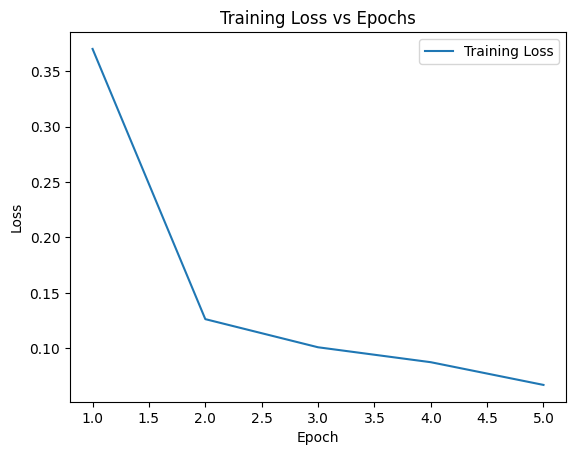

<Figure size 640x480 with 0 Axes>

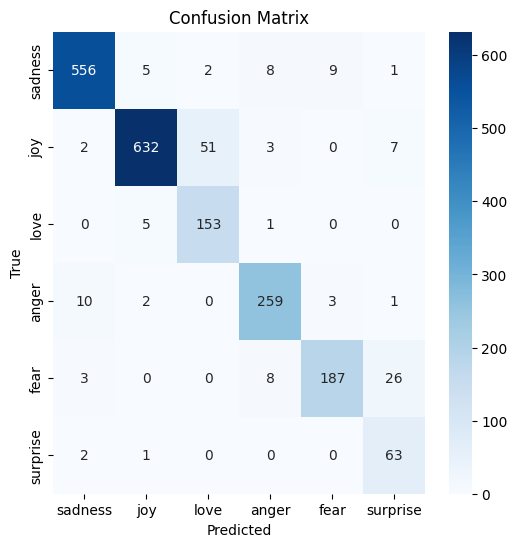

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       581
           1       0.98      0.91      0.94       695
           2       0.74      0.96      0.84       159
           3       0.93      0.94      0.94       275
           4       0.94      0.83      0.88       224
           5       0.64      0.95      0.77        66

    accuracy                           0.93      2000
   macro avg       0.87      0.93      0.89      2000
weighted avg       0.94      0.93      0.93      2000



In [12]:
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Pad the sequences
def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  labels = [item['label'] for item in batch]

  input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
  attention_mask = pad_sequence(attention_mask,batch_first=True,padding_value=0)

  return {
      'input_ids': input_ids,
      'attention_mask': attention_mask,
      'label': torch.tensor(labels)
  }

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle = True, collate_fn = collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle = False, collate_fn = collate_fn)

# Set number of epochs - Used later for data representation displayed
epoch_val = 5

# Train is placed into variable names history for use in data representation later
history = train(model, train_loader, optimizer, loss_fn, device,epoch_val)
# # Displays all results of loss from history, used for debugging
# print(history)
# Accuracy calculated and used for confusion matrix later
accuracy = evaluate(model, test_loader, device)
print(f'Test Accuracy: {accuracy:.3f}')

# Loss graph for training
plt.figure(1)
plt.plot(range(1, epoch_val + 1), history , label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.legend()
plt.show()

# Confusion matrix
plt.figure(2)
true_labels, predictions = eval_conf_matrix(model, test_loader, device)

# Print confusion matrix - Debug test
#print("Confusion Matrix:", conf_mat)

conf_mat = confusion_matrix(true_labels,predictions)
plt.figure(figsize = (6,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset['train'].features['label'].names,
            yticklabels=dataset['train'].features['label'].names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classsification report
print("Classification Report for DistilBERT:")
print(classification_report(true_labels, predictions))

CODE FOR BERT ENDS AND Naive Bayes BEGINS

## Model 2:
Step 1: Imports and installs

In [10]:
# Installs necessary
!pip install transformers
!pip install datasets

In [153]:
# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
# dataset import
from datasets import load_dataset
# sklearn import
# Initially used count vectoriser, attempted tfidf vectoriser
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# extra imports to get heatmap for confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Imports for custom naive bayes model
import torch.nn.functional as F
import numpy as np
from torch.optim import AdamW as Adam

Loading dataset

In [154]:
# Load dataset similar to BERT
dataset = load_dataset('emotion',trust_remote_code = True)
# Data is already split in huggingface (16k train, 2k test 2k validation)
train_data = dataset['train']
test_data = dataset['test']
val_data = dataset['validation']

Step 2: Vectorisation of data

In [164]:
# CODE FOR USING COUNTVECTORISER
# Uses countVectoriser() to tokenise and vectorise data
# Hyperparameters for count vectoriser
# Best values currently for accuracy are 8,0.85,1,3
min_df_val = 8
max_df_val = 0.85
ngram_val_min = 1
ngram_val_max = 3
# Count vectoriser with hyperparams count vectoriser automatically tokenises and vectorises data
vectoriser_nb = CountVectorizer(min_df=min_df_val, max_df=max_df_val, ngram_range=(ngram_val_min, ngram_val_max))
# Setting values into data for checking
# Combine train and val then split after fitting
combined_texts = train_data["text"] + val_data["text"]
X_combined = vectoriser_nb.fit_transform(combined_texts)
X_train = X_combined[:len(train_data)]
X_val = X_combined[len(train_data):len(train_data)+len(val_data)]
X_test = vectoriser_nb.transform(test_data["text"])
# Define labels for each set
y_train = train_data["label"]
y_test = test_data["label"]
y_val = val_data["label"]

TFIDF CODE (IS COMMMENTED OUT TO PREVENT OVERLAPPING IN CODE) RESULTS IN LOWER OVERALL ACCURACY

In [4]:
# # CODE FOR TFIDF VECTORISER
# # Splits text, splits by whitespace so ngrams will not function with this
# def tokeniser(text):
#   return text.split()

# # Convert to strings to allow for tokenisation
# train_texts_tfidf = [example['text'] for example in train_data]
# test_texts_tfidf = [example['text'] for example in test_data]
# val_texts_tfidf = [example['text'] for example in val_data]

# # count vectoriser to count frequency of tokens
# # Hyperparams for countvectoriser
# min_df_val = 8
# max_df_val = 0.85
# ngram_val_min = 1
# ngram_val_max = 3
# count_vectoriser_tfidf = CountVectorizer(tokenizer=tokeniser, min_df=min_df_val, max_df=max_df_val, ngram_range=(ngram_val_min, ngram_val_max))
# X_train_num = count_vectoriser_tfidf.fit_transform(train_texts_tfidf)
# X_test_num = count_vectoriser_tfidf.transform(test_texts_tfidf)
# X_val_num = count_vectoriser_tfidf.transform(val_texts_tfidf)

# # Transform the data  to tfidf
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_num)
# X_test_tfidf = tfidf_transformer.transform(X_test_num)
# X_val_tfidf = tfidf_transformer.transform(X_val_num)

# # Define labels for each set
# y_train = train_data["label"]
# y_test = test_data["label"]
# y_val = val_data["label"]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


 Step 3: Creation of model and hyperparameters involved

In [165]:
# Make the model a Naive Bayes multinomial for the 6 potential labels
# Setting Hyperparameter in order to  tweak results
# Best value right now for alpha with other hyperparams is 0.45
alpha_val = 0.45
model = MultinomialNB(alpha=alpha_val)

Step 4: Fitting model

In [166]:
# Model for regular countvectoriser
model.fit(X_train, y_train)
# # test to use tfidf for model instead
# model.fit(X_train_tfidf,y_train)

MultinomialNB(alpha=0.45)

Step 4.5: Validation of dataset

In [167]:
# Cross-validation used, hyperparam for cv
# Not the best result for val but produces best result for accuracy is 10 fold
cross_fold_val = 10
# # Version for tfidf - Accuracy is lower at 0.524
#acc_scores = cross_val_score(model, X_val_tfidf, y_val, cv=cross_fold_val)
# Version for count Vectoriser
acc_scores = cross_val_score(model, X_val, y_val, cv=cross_fold_val)
print("Cross-validation scores:", acc_scores)
print("Mean accuracy:", acc_scores.mean())

Cross-validation scores: [0.66  0.6   0.605 0.605 0.61  0.615 0.65  0.635 0.62  0.53 ]
Mean accuracy: 0.6130000000000001


Step 5: Evaluation of model and resulting accuracy

In [168]:
# # Version of tfidf - Accuracy results in 0.7265, about 6% lower than regular vectoriser, LEAVE TFIDF CODE COMMENTED
# y_predict = model.predict(X_test_tfidf)
# # Versino for countvectoriser
y_predict = model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_predict)
print("Accuracy: ", accuracy_nb)
# Best Accuracy right now is 0.797
# Places into confusion matrix
conf_mat_NB = confusion_matrix(y_test, y_predict)

Accuracy:  0.797


Step 6: Displaying results

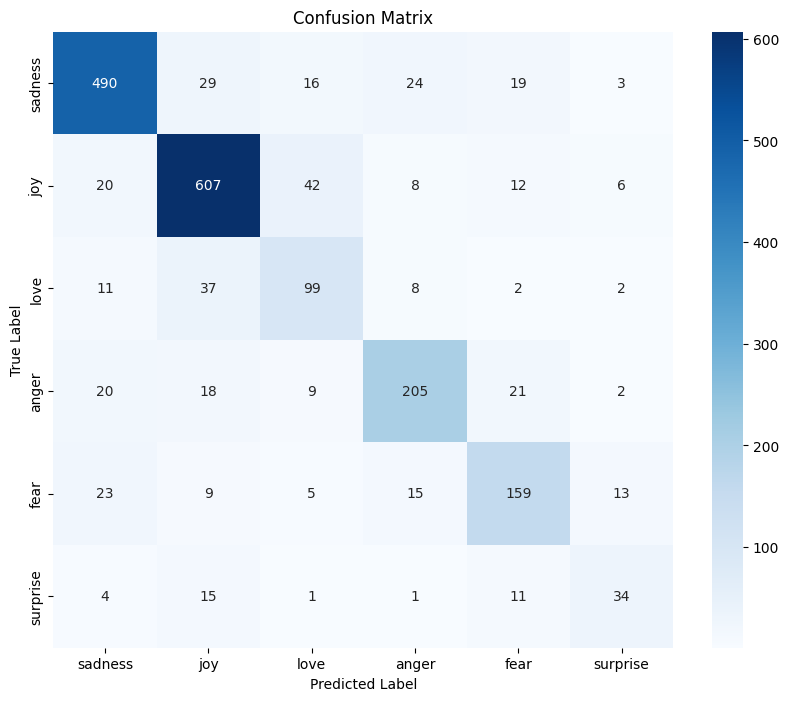

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       581
           1       0.85      0.87      0.86       695
           2       0.58      0.62      0.60       159
           3       0.79      0.75      0.76       275
           4       0.71      0.71      0.71       224
           5       0.57      0.52      0.54        66

    accuracy                           0.80      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.80      0.80      0.80      2000



In [169]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_NB, annot=True, fmt="d", cmap="Blues", xticklabels=dataset["train"].features["label"].names, yticklabels=dataset["train"].features["label"].names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print Classification Report, gets crucial info for report
print("Classification Report for Naive Bayes:")
print(classification_report(y_test, y_predict))

Error Analysis: Misclassified Data

In [171]:
misclassified_examples = []
for i, (text, true_label) in enumerate(zip(test_data["text"], y_test)):
    text_features = vectoriser_nb.transform([text])
    predicted_label = model.predict(text_features)[0]
    if predicted_label != true_label:
        misclassified_examples.append((text, predicted_label, true_label))

print("Misclassified Examples:")
for i, (text, predicted_label, true_label) in enumerate(misclassified_examples[:5]):
    print(f"Example {i + 1}:")
    print("Text:", text)
    print("Predicted Label:", predicted_label)
    print("True Label:", true_label)
    print()

# REFERENCE FOR LABELS AND WHAT THEY ARE
# 0 = JOY
# 1 = SADNESS
# 2 = ANGER
# 3 = FEAR
# 4 = LOVE
# 5 = SURPRISE

Misclassified Examples:
Example 1:
Text: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
Predicted Label: 4
True Label: 1

Example 2:
Text: i jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week and im about as fit as a walrus on vacation for the summer
Predicted Label: 0
True Label: 3

Example 3:
Text: i don t feel particularly agitated
Predicted Label: 3
True Label: 4

Example 4:
Text: i feel beautifully emotional knowing that these women of whom i knew just a handful were holding me and my baba on our journey
Predicted Label: 2
True Label: 0

Example 5:
Text: i pay attention it deepens into a feeling of being invaded and helpless
Predicted Label: 0
True Label: 4

